In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2 
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import operator 
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataframe = pd.read_csv('Data/chinese_mnist.csv')
index = dataframe.iloc[:,:-2].values 
value = dataframe["code"].values

In [3]:
dataframe

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九
...,...,...,...,...,...
14995,99,5,9,8,八
14996,99,6,9,8,八
14997,99,7,9,8,八
14998,99,8,9,8,八


In [4]:
print(index.shape)
print(len(value))

(15000, 3)
15000


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   15000 non-null  int64 
 1   sample_id  15000 non-null  int64 
 2   code       15000 non-null  int64 
 3   value      15000 non-null  int64 
 4   character  15000 non-null  object
dtypes: int64(4), object(1)
memory usage: 586.1+ KB


In [6]:
filename_label_link = {}
filename_list = []
label_list = []
listImageArray = []
listImageNameArray = [] 
for i in range(0,len(value)):
    codeImage= index[i]
    filename = "input_%s_%s_%s.jpg" % (codeImage[0], codeImage[1], codeImage[2])
    val = value[i] 
    filename_label_link[filename] = val
    filename_list.append(filename)
    label_list.append(val)
    a = cv2.imread("Data/data/%s"%filename,0)
    listImageArray.append(a)
    listImageNameArray.append(val)

In [7]:
listImageArray = np.array(listImageArray)
listImageNameArray = np.array(listImageNameArray)
print(listImageArray.shape)
print(listImageNameArray.shape)
listImageNameArray_copy=listImageNameArray.copy()

(15000, 64, 64)
(15000,)


In [8]:
print("Before flatten:",listImageArray.shape)

listFlattened = []

# Duoi thang tung tam hinh ra 64x64 = 4096 cot
for i in range(len(listImageArray)):
    listFlattened.append(listImageArray[i].flatten()/255)


listFlattened = np.array(listFlattened)
listFlattenedScale = scale(listFlattened)
listFlattenedScale_copy=listFlattenedScale.copy()

Before flatten: (15000, 64, 64)


In [9]:
print(listFlattenedScale.shape)

(15000, 4096)


In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(listFlattenedScale,listImageNameArray, test_size = 0.2, random_state = 10)
print("x_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("x_train[0] shape: ",X_train[0])
print("x_test: ",X_test.shape)
print("y_test: ",y_test.shape)
print("y_test[0] shape: ",y_test[0])

x_train:  (12000, 4096)
y_train:  (12000,)
x_train[0] shape:  [ 0.          0.          0.         ... -0.01516048 -0.01558956
 -0.0139023 ]
x_test:  (3000, 4096)
y_test:  (3000,)
y_test[0] shape:  8


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model selection

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import KFold

In [13]:
models=[
    LogisticRegression(multi_class='auto',max_iter=1000),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=50),
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='rbf'),
    SVC(kernel='linear'),
    KNeighborsClassifier(n_neighbors=6),
    KNeighborsClassifier(n_neighbors=12)
]

In [14]:
def get_model_name(model):
    model_name=model.__class__.__name__
    if model_name=='RandomForestClassifier':
        model_name+='_'+str(model.n_estimators)
    elif model_name=='KNeighborsClassifier':
        model_name+='_'+str(model.n_neighbors)
    elif model_name=='SVC':
        model_name+='_'+str(model.kernel)
    return model_name

In [15]:
import datetime
x1 = datetime.datetime.now()
print(x1)

2022-10-04 09:15:59.648844


In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(.95)

In [18]:
pca.fit(X_train)

PCA(n_components=0.95)

In [19]:
pca.n_components_

1108

In [20]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#### *Lượng data là quá lớn để có thể chạy model selection

In [25]:
from tqdm import tqdm
import datetime
kf=KFold(n_splits=10)
cv_df=pd.DataFrame(columns=['model','mean_score','std_score','accuracy_train','accuracy_test','time'])
for model in tqdm(models):
    model_name=get_model_name(model)
    start_time=datetime.datetime.now()
    cv_score=cross_val_score(model,X_train,y_train,cv=kf,n_jobs=-1)
    end_time=datetime.datetime.now()
    time_taken=end_time-start_time
    model.fit(X_train,y_train)
    accuracy_train=round(model.score(X_train,y_train)*100,3)
    accuracy_test=round(model.score(X_test,y_test)*100,3)
    cv_df=pd.concat([cv_df,pd.DataFrame.from_records([
        {
            'model':model_name,
            'mean_score':cv_score.mean(),
            'std_score':cv_score.std(),
            'accuracy_train':accuracy_train,
            'accuracy_test':accuracy_test,
            'time':str(time_taken),
        }
    ])],ignore_index=True)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\PMinhQuang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [48:32<00:00, 323.61s/it]


In [32]:
metrics=cv_df.sort_values(by=['mean_score'],ascending=False)
metrics

,model,mean_score,std_score,accuracy_train,accuracy_test,time
4,RandomForestClassifier_100,0.661083,0.014245,100.0,68.533,0:01:58.651594
3,RandomForestClassifier_50,0.629333,0.009367,100.0,65.5,0:01:05.998724
5,SVC_rbf,0.569417,0.011595,71.683,59.333,0:15:16.114930
7,KNeighborsClassifier_6,0.514083,0.015021,66.292,53.533,0:00:05.561512
8,KNeighborsClassifier_12,0.49,0.01353,58.558,51.133,0:00:04.110018
6,SVC_linear,0.470583,0.008772,98.858,48.9,0:09:24.057653
0,LogisticRegression,0.426,0.009135,80.025,45.767,0:06:24.086924
2,DecisionTreeClassifier,0.413583,0.01523,100.0,43.0,0:01:48.175878
1,GaussianNB,0.165,0.010788,17.55,15.533,0:00:04.431593


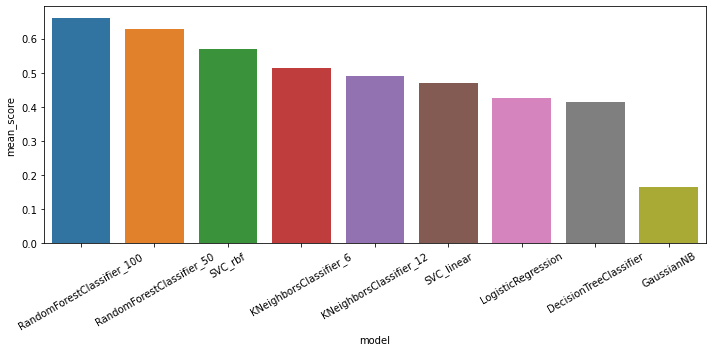

In [33]:
plt.figure(figsize=(10,5),tight_layout=True)
sns.barplot(x='model',y='mean_score',data=metrics)
plt.xticks(rotation=30)
plt.show()

In [36]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [37]:
y_pred = clf.predict(X_test)

In [38]:
y_pred

array([ 8, 10,  8, ..., 12,  3,  7], dtype=int64)

In [39]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(y_test,y_pred)*100,"%")

Accuracy is  59.333333333333336 %


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[183   0   0   0   3   0   3   0   0   1   2   9   2   6   0]
 [  2 181  17   3   0   0   2   0   0   0   0   0   0   0   0]
 [  9  49  99  30   0   0   4   0   4   0   2   0   0   0   0]
 [  9  12  14 107   0   8  17   4   1   0   5   1   7   0   0]
 [  8   1   4   3 147   0   5   3   0   2   9   8   3   7   4]
 [ 17   1   2  12   3 114   4   5   9   6  12   7   0   1   1]
 [  9  22   5   7   2   0 121   5   8  10   6   0   3   4   1]
 [  5   9   7   1   1   2   4 105   9   6  11   2   4  12   9]
 [  9  38   3   3   0   0  16   1 135   1   0   0   3   0   2]
 [ 18   0   5   1   1   6  17  37   4  77   1   9   6  14  10]
 [  3  19   1   2   3   0   7   2   8   0 128   1  27   1   0]
 [ 12   0   0   1   8   7   2  10   5   5  11  94   1  22   0]
 [ 18   5   4   6   1   0  20   1   1   1  63   0  86   3   1]
 [ 18   2   0   7   1   1   8  16   5   9  20  10   4  88   1]
 [ 22   3   3   6   3   0  12  23   2  17   2   0   6   5 115]]
              precision    recall  f1-score   support


In [41]:
from sklearn import metrics
print("Precision:",metrics.precision_score(y_test, y_pred,pos_label='positive',
                                           average='micro'))
print("Recall:",metrics.recall_score(y_test, y_pred,pos_label='positive',
                                           average='micro'))

Precision: 0.5933333333333334
Recall: 0.5933333333333334


C:\Users\PMinhQuang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\PMinhQuang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [42]:
x2 = datetime.datetime.now()
print(x2)

2022-10-04 11:14:53.486846


In [43]:
d = x2 - x1

In [44]:
print(d)

1:58:53.838002


Text(0, 0.5, 'Cumulative explained variance')

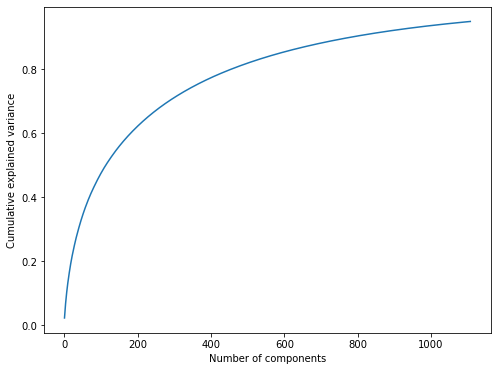

In [45]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

#### Nhận xét: Model chạy nhanh hơn sau khi giảm chiều

In [46]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(listFlattenedScale_copy,listImageNameArray_copy, test_size = 0.2, random_state = 10)
print("x_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("x_train[0] shape: ",X_train[0])
print("x_test: ",X_test.shape)
print("y_test: ",y_test.shape)
print("y_test[0] shape: ",y_test[0])

x_train:  (12000, 4096)
y_train:  (12000,)
x_train[0] shape:  [ 0.          0.          0.         ... -0.01516048 -0.01558956
 -0.0139023 ]
x_test:  (3000, 4096)
y_test:  (3000,)
y_test[0] shape:  8


In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
x3 = datetime.datetime.now()
print(x3)

2022-10-04 11:15:04.519315


In [49]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [50]:
y_pred = clf.predict(X_test)

In [51]:
y_pred

array([ 6, 15,  8, ...,  8, 15,  7], dtype=int64)

In [52]:
from sklearn.metrics import accuracy_score
print("Accuracy is ", accuracy_score(y_test,y_pred)*100,"%")

Accuracy is  47.733333333333334 %


In [53]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[158   0   0   2   6   5   2   2   0   3   2  18   6   5   0]
 [  0 160  22   6   2   0   3   1   1   0   9   1   0   0   0]
 [  0  23  90  41   1   6   3   5  11   1   7   1   2   2   4]
 [  0   2  27  98   3  19   3   3   4   6   4   1   8   5   2]
 [ 10   0   2   1 121  12   2   7   0   6   3   9   4   7  20]
 [  6   1   3  16   4  90   2   9   5  20   4  15   8   2   9]
 [  4  10  16  10   8   2  77   7   6  24   8   3  10  11   7]
 [  3   0  10   2   9  18   4  78  11  17   7   9   4   6   9]
 [  0  25  22   3   2   4  18   5 118   5   2   1   2   1   3]
 [  6   0   4   7   6  23  14  27   3  63   1  10   6  17  19]
 [  6   9   3   2  10   6   4   9   2   2 106   1  35   7   0]
 [ 15   0   0   1  23  22   3  10   3   6  19  57   6  10   3]
 [ 12   2   4  10   5   6  17  10   0   6  37   9  81   3   8]
 [ 13   2   4   8   8   8   7  19   5  16   8  21   8  58   5]
 [  8   0   7   2  25  11   7  26  10  25   3   7   4   7  77]]
              precision    recall  f1-score   support


In [54]:
from sklearn import metrics
print("Precision:",metrics.precision_score(y_test, y_pred,pos_label='positive',
                                           average='micro'))
print("Recall:",metrics.recall_score(y_test, y_pred,pos_label='positive',
                                           average='micro'))

Precision: 0.47733333333333333
Recall: 0.47733333333333333


C:\Users\PMinhQuang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\PMinhQuang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [55]:
x4 = datetime.datetime.now()
print(x4)

2022-10-04 11:24:13.032587


In [56]:
d2 = x4 - x3

In [57]:
print(d2)

0:09:08.513272


In [58]:
d2-d

datetime.timedelta(days=-1, seconds=79814, microseconds=675270)

#### Nhận xét: SVM chạy nhanh hơn sau khi giảm chiều